In [9]:
import os
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn

from sklearn.metrics import balanced_accuracy_score 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.data.medical_imaging import get_chexpert

os.makedirs(PLOTS_PATH, exist_ok=True)

In [10]:
method_seeds = [42, 142, 242, 342, 442]
dseed = 42

model = ["resnet18", "resnet34", "resnet50"][2]

verbose = False

pas = ["old", "woman", "white"]
pa = 0 # 0, 1, 2

In [11]:
full_ds, _, _ = get_chexpert(load_to_ram=False)

run_path = os.path.join(RESULTS_PATH, f"chexpert_{model}_mseed{method_seeds[0]}_dseed{dseed}")
fair_inds = torch.load(os.path.join(run_path, "fair_inds.pt"))
val_inds = torch.load(os.path.join(run_path, "val_inds.pt"))

print(len(fair_inds), len(val_inds))

y_fair_t = full_ds.targets[fair_inds]
a_fair_t = full_ds.protected_attributes[pa, fair_inds]
y_val_t = full_ds.targets[val_inds]
a_val_t = full_ds.protected_attributes[pa, val_inds]

# switch 0 / 1 in protected attribute
pas = ["young", "man", "non-white"]
a_fair_t = 1 - a_fair_t
a_val_t = 1 - a_val_t

# switch label
# y_fair_t = 1 - y_fair_t
# y_val_t = 1 - y_val_t

p_a_val = a_val_t.float().mean().item() * 100

# patients general 65401
# patients with race 58010
24638 24638


In [12]:
# load probits
fair_probits, val_probits = list(), list()
for mseed in method_seeds:
    path = os.path.join(RESULTS_PATH, f"chexpert_{model}_mseed{mseed}_dseed{dseed}")

    # don't do fairness ensemble on medical imaging - use this split as test dataset
    fp = torch.load(os.path.join(path, f"fair_probits.pt"))
    #fp = 1 - fp
    fair_probits.append(fp)
    vp = torch.load(os.path.join(path, f"val_probits.pt"))
    #vp = 1 - vp
    val_probits.append(vp)

### Optimize Thresholds

In [13]:
thresholds = np.linspace(0, 1, 1001)

In [14]:
ensemble_best_thresholds = list()
member_best_thresholds = list()
ensemble_thresholds, ensemble_accs = list(), list()
member_thresholds, member_accs = list(), list()

for m in tqdm(range(len(method_seeds))):
    threshs, accs = [[], [], []], [[], [], []]
    best_thresholds, best_accs = [0, 0, 0], [0, 0, 0]

    val_m_probits = torch.mean(val_probits[m], dim=0)

    X = np.array(range(len(y_val_t)))
    y = y_val_t.numpy()
    group=a_val_t.numpy()
    y_scores = val_m_probits[:, -1].numpy()

    for thr in thresholds:
        preds = y_scores > thr
        for g in range(3):
            if g == 2:
                acc = balanced_accuracy_score(y, preds)
            else:
                acc = balanced_accuracy_score(y[group == g], preds[group == g])
            if acc >= best_accs[g]:
                best_accs[g] = acc
                best_thresholds[g] = thr
            threshs[g].append(thr)
            accs[g].append(acc)
    
    ensemble_thresholds.append(threshs)
    ensemble_accs.append(accs)
    
    ensemble_best_thresholds.append(best_thresholds)

    for me, member_probits in enumerate(val_probits[m]):
        threshs, accs = [[], [], []], [[], [], []]
        best_thresholds, best_accs = [0, 0, 0], [0, 0, 0] 
        
        y_scores = member_probits[:, -1].numpy()
        for thr in thresholds:
            preds = y_scores > thr
            for g in range(3):
                if g == 2:
                    acc = balanced_accuracy_score(y, preds)
                else:
                    acc = balanced_accuracy_score(y[group == g], preds[group == g])
                if acc > best_accs[g]:
                    best_accs[g] = acc
                    best_thresholds[g] = thr
                threshs[g].append(thr)
                accs[g].append(acc)

        member_thresholds.append(threshs)
        member_accs.append(accs)

        member_best_thresholds.append(best_thresholds)

ensemble_best_thresholds = np.asarray(ensemble_best_thresholds)
member_best_thresholds = np.asarray(member_best_thresholds)
ensemble_thresholds = np.asarray(ensemble_thresholds)
ensemble_accs = np.asarray(ensemble_accs)
member_thresholds = np.asarray(member_thresholds)
member_accs = np.asarray(member_accs)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [06:00<00:00, 72.02s/it]


In [15]:
ensemble_best_thresholds = np.asarray(ensemble_best_thresholds)
member_best_thresholds = np.asarray(member_best_thresholds)

print("-"*30)
for thrs in [ensemble_best_thresholds, member_best_thresholds]:
    print(f"${np.mean(thrs[:, -1]):.3f}_{'{'}\pm {np.std(thrs[:, -1]):.3f}{'}'}$")
    for i in range(2):
        print(f"Group {i}")
        print(f"${np.mean(thrs[:, i]):.3f}_{'{'}\pm {np.std(thrs[:, i]):.3f}{'}'}$")
    print("-"*30)  

------------------------------
$0.162_{\pm 0.007}$
Group 0
$0.147_{\pm 0.009}$
Group 1
$0.216_{\pm 0.022}$
------------------------------
$0.138_{\pm 0.014}$
Group 0
$0.124_{\pm 0.014}$
Group 1
$0.231_{\pm 0.038}$
------------------------------


(5, 3)


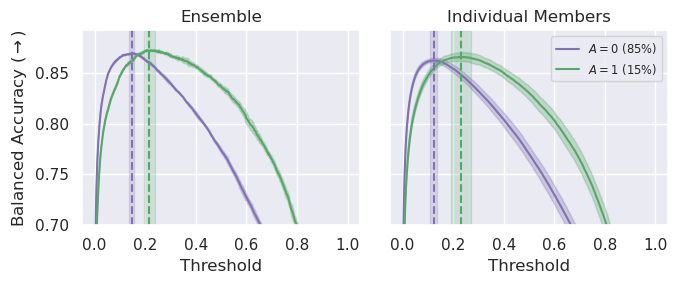

In [16]:
plot_both = False

f, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

axs[0].plot(thresholds, np.mean(ensemble_accs[:, 0], axis=0), label=f"$A=0$ ({(100 - p_a_val):.0f}%)", color="C4")
axs[0].fill_between(thresholds, 
                    np.mean(ensemble_accs[:, 0], axis=0) - np.std(ensemble_accs[:, 0], axis=0), 
                    np.mean(ensemble_accs[:, 0], axis=0) + np.std(ensemble_accs[:, 0], axis=0), 
                    alpha=0.3, color="C4")
axs[0].plot(thresholds, np.mean(ensemble_accs[:, 1], axis=0), label=f"$A=1$ ({(p_a_val):.0f}%)", color="C2")
axs[0].fill_between(thresholds,
                    np.mean(ensemble_accs[:, 1], axis=0) - np.std(ensemble_accs[:, 1], axis=0), 
                    np.mean(ensemble_accs[:, 1], axis=0) + np.std(ensemble_accs[:, 1], axis=0), 
                    alpha=0.3, color="C2")
if plot_both:
    axs[0].plot(thresholds, np.mean(ensemble_accs[:, 2], axis=0), label="$Both$", color="black")
    axs[0].fill_between(thresholds,
                        np.mean(ensemble_accs[:, 2], axis=0) - np.std(ensemble_accs[:, 2], axis=0), 
                        np.mean(ensemble_accs[:, 2], axis=0) + np.std(ensemble_accs[:, 2], axis=0), 
                        alpha=0.3, color="black")
axs[1].plot(thresholds, np.mean(member_accs[:, 0], axis=0), label=f"$A=0$ ({(100 - p_a_val):.0f}%)", color="C4")
axs[1].fill_between(thresholds, 
                    np.mean(member_accs[:, 0], axis=0) - np.std(member_accs[:, 0], axis=0), 
                    np.mean(member_accs[:, 0], axis=0) + np.std(member_accs[:, 0], axis=0), 
                    alpha=0.3, color="C4")
axs[1].plot(thresholds, np.mean(member_accs[:, 1], axis=0), label=f"$A=1$ ({(p_a_val):.0f}%)", color="C2")
axs[1].fill_between(thresholds,
                    np.mean(member_accs[:, 1], axis=0) - np.std(member_accs[:, 1], axis=0), 
                    np.mean(member_accs[:, 1], axis=0) + np.std(member_accs[:, 1], axis=0), 
                    alpha=0.3, color="C2")
if plot_both:
    axs[1].plot(thresholds, np.mean(member_accs[:, 2], axis=0), label="$Both$", color="black")
    axs[1].fill_between(thresholds,
                        np.mean(member_accs[:, 2], axis=0) - np.std(member_accs[:, 2], axis=0), 
                        np.mean(member_accs[:, 2], axis=0) + np.std(member_accs[:, 2], axis=0), 
                        alpha=0.3, color="black")
    
y_min = 0.7
y_max = plt.gca().get_ylim()[1]

print(ensemble_best_thresholds.shape)
axs[0].vlines(np.mean(ensemble_best_thresholds, axis=0)[0], y_min, y_max, color="C4", linestyle="--")
# fill between two vlines
axs[0].axvspan(np.mean(ensemble_best_thresholds, axis=0)[0] - np.std(ensemble_best_thresholds, axis=0)[0],
                np.mean(ensemble_best_thresholds, axis=0)[0] + np.std(ensemble_best_thresholds, axis=0)[0],
                color="C4", alpha=0.2)
axs[0].vlines(np.mean(ensemble_best_thresholds, axis=0)[1], y_min, y_max, color="C2", linestyle="--")
axs[0].axvspan(np.mean(ensemble_best_thresholds, axis=0)[1] - np.std(ensemble_best_thresholds, axis=0)[1],
                np.mean(ensemble_best_thresholds, axis=0)[1] + np.std(ensemble_best_thresholds, axis=0)[1],
                color="C2", alpha=0.2)
axs[1].vlines(np.mean(member_best_thresholds, axis=0)[0], y_min, y_max, color="C4", linestyle="--")
axs[1].axvspan(np.mean(member_best_thresholds, axis=0)[0] - np.std(member_best_thresholds, axis=0)[0],
                np.mean(member_best_thresholds, axis=0)[0] + np.std(member_best_thresholds, axis=0)[0],
                color="C4", alpha=0.2)
axs[1].vlines(np.mean(member_best_thresholds, axis=0)[1], y_min, y_max, color="C2", linestyle="--")
axs[1].axvspan(np.mean(member_best_thresholds, axis=0)[1] - np.std(member_best_thresholds, axis=0)[1],
                np.mean(member_best_thresholds, axis=0)[1] + np.std(member_best_thresholds, axis=0)[1],
                color="C2", alpha=0.2)

axs[1].legend(fontsize="x-small")
axs[0].set_title("Ensemble")
axs[1].set_title("Individual Members")
axs[0].set_xlabel("Threshold")
axs[1].set_xlabel("Threshold")
axs[0].set_ylabel("Balanced Accuracy ($\\rightarrow$)")
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_thresholds.pdf"))
plt.show()